# Summary of filters

Families:
* Remove 11299, outlier with 893 total denovos

In [124]:
%pylab inline

import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.stats

Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.4/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['diff', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [125]:
# Load data (by child/family)
RESDIR="/storage/mgymrek/ssc-denovos/denovos2/denovocalls/"
#PERIOD=2
#bychild = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_bychild2_period%s.tab"%PERIOD), sep="\t")
bychild = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_bychild2.tab"), sep="\t")

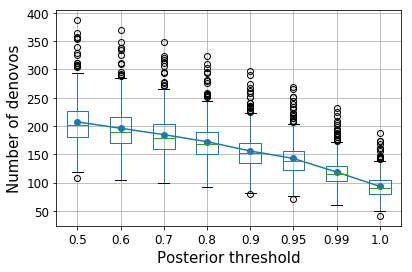

In [126]:
# For unaffecteds, get total de novos by threshold
fig = plt.figure()
ax = fig.add_subplot(111)
bp = bychild[(bychild["status"]==1) & (bychild["pthresh"]!=0)].boxplot(by="pthresh", column="numutations", ax=ax,
                                                                 return_type="dict")
ax.set_title("");
fig.suptitle("")
ax.set_xlabel("");
ax.set_ylabel("Number of denovos", size=15)
ax.set_xlabel("Posterior threshold", size=15)
ax.set_xticklabels(ax.get_xticklabels(), size=12);
ax.set_yticklabels([int(x) for x in ax.get_yticks()], size=12);

# Plot means
bychild_means = bychild[(bychild["status"]==1) & (bychild["pthresh"]!=0)].groupby("pthresh", as_index=False).agg({"numutations": np.mean})
ax.plot(ax.get_xticks(), bychild_means["numutations"], marker="o")

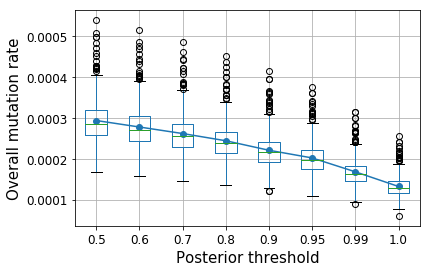

In [127]:
# For unaffecteds, get rate by threshold

bychild_totals = bychild[(bychild["pthresh"]==0)].groupby(["family","child","status"], as_index=False).agg({"numutations": np.max})
bychild_totals["total"] = bychild_totals["numutations"]
bychild_rates = pd.merge(bychild, bychild_totals[["family","child","status","total"]], on=["family","child","status"])
bychild_rates["rate"] = bychild_rates.apply(lambda x: x["numutations"]*1.0/x["total"], 1)
bychild_rates = bychild_rates[~((bychild_rates["pthresh"]==0) & (bychild_rates["rate"]<1))] # TODO remove after fix

fig = plt.figure()
ax = fig.add_subplot(111)
bp = bychild_rates[(bychild_rates["status"]==1) & (bychild_rates["pthresh"]!=0)].boxplot(by="pthresh", column="rate", ax=ax,
                                                                 return_type="dict")
ax.set_title("");
fig.suptitle("")
ax.set_xlabel("");
ax.set_ylabel("Overall mutation rate", size=15)
ax.set_xlabel("Posterior threshold", size=15)
ax.set_xticklabels(ax.get_xticklabels(), size=12);
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);

# Plot means
bychild_means = bychild_rates[(bychild_rates["status"]==1) & (bychild_rates["pthresh"]!=0)].groupby("pthresh", as_index=False).agg({"rate": np.mean})
ax.plot(ax.get_xticks(), bychild_means["rate"], marker="o")

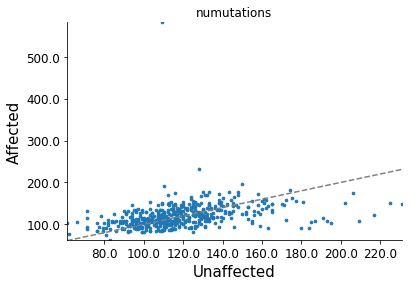

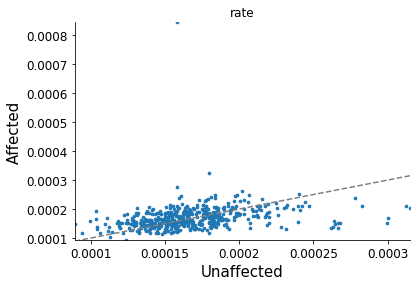

In [128]:
# Plot by child for each family
pthresh = 0.99
buf = 10
unaffected = bychild_rates[(bychild_rates["status"]==1) & (bychild_rates["pthresh"] == pthresh)]
affected = bychild_rates[(bychild_rates["status"]==2) & (bychild_rates["pthresh"] == pthresh)]
sibs = pd.merge(unaffected, affected, on=["family"])

for col in ["numutations","rate"]:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(sibs["%s_x"%col], sibs["%s_y"%col], s=7)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')

    ax.set_xlabel("Unaffected", size=15)
    ax.set_ylabel("Affected", size=15)
    minval = min(list(unaffected[col])+list(affected[col]))
    maxval = max(list(unaffected[col])+list(affected[col]))
    ax.plot([minval, maxval],[minval,maxval], color="gray", linestyle="dashed")
    ax.set_xlim(left=min(unaffected[col]), right=max(unaffected[col]))
    ax.set_ylim(bottom=min(affected[col]), top=max(affected[col]))
    ax.set_xticklabels(ax.get_xticks(), size=12);
    ax.set_yticklabels(ax.get_yticks(), size=12);
    ax.set_title(col)

Ttest_1sampResult(statistic=0.32762249831929297, pvalue=0.7433417601254424)
Ks_2sampResult(statistic=0.056842105263157916, pvalue=0.41630774772310269)


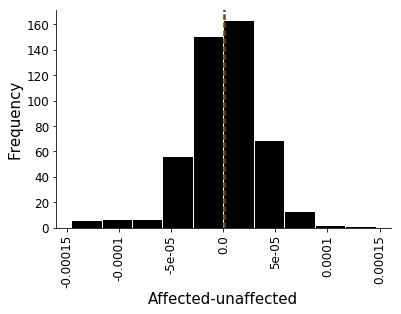

In [129]:
# Histogram of diff in affected-unaffected
fig = plt.figure()
ax = fig.add_subplot(111)
u = sibs[sibs["family"] != 11299]["rate_x"]
a = sibs[sibs["family"] != 11299]["rate_y"]
diff = a-u
ax.hist(diff,
        color="black", edgecolor="white");
ax.set_xlabel("Affected-unaffected", size=15);
ax.set_ylabel("Frequency", size=15);
ax.set_xticklabels(map(lambda x: (x), ax.get_xticks()), size=12, rotation=90);
ax.set_yticklabels(map(lambda x: int(x), ax.get_yticks()), size=12);
ax.axvline(np.median(diff), color="red", linestyle="dashed")
ax.axvline(np.mean(diff), color="green", linestyle="dashed")
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
print(str(scipy.stats.ttest_1samp(diff, popmean=0)))
print(str(scipy.stats.ks_2samp(u, a)))

EUR vs. AFR	Ks_2sampResult(statistic=0.52633199876809356, pvalue=0.00012405703688693451)
EUR vs. ASIA	Ks_2sampResult(statistic=0.27724892908138982, pvalue=0.066526508482017757)
AFR vs. ASIA	Ks_2sampResult(statistic=0.4866310160427807, pvalue=0.013347908153953007)
EUR vs. AFR	Ttest_indResult(statistic=-3.9154759736387819, pvalue=0.00010618251486317612)
EUR vs. ASIA	Ttest_indResult(statistic=0.79251319743758364, pvalue=0.42852893808951609)
AFR vs. ASIA	Ttest_indResult(statistic=2.9307671222922758, pvalue=0.0057655150526245572)


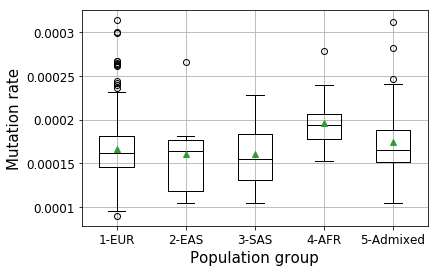

In [130]:
# Plot by population
pthresh = 0.99
sscpop = pd.read_csv("../../metadata/ssc_family_populations.tab", sep="\t")
sscpop = pd.merge(sscpop, bychild_rates[(bychild_rates["status"]==1) & (bychild_rates["pthresh"]==pthresh)],
                  on=["family"])
fig = plt.figure()
ax = fig.add_subplot(111)
boxprops = dict(linestyle='-', linewidth=1)
medianprops = dict(linestyle='-', linewidth=1)

poplabels = {
    "EUR": "1-EUR",
    "EAS": "2-EAS",
    "SAS": "3-SAS",
    "AFR": "4-AFR",
    "Admixed": "5-Admixed"
}
sscpop["SuperpopLabel"] = sscpop["Superpop"].apply(lambda x: poplabels[x])
bp = sscpop.boxplot(by="SuperpopLabel", column="rate", ax=ax, boxprops=boxprops,
                medianprops=medianprops, return_type='dict', showmeans=True);
[[item.set_color("black") for item in bp[key]['boxes']] for key in bp.keys()]
[[item.set_color("black") for item in bp[key]['medians']] for key in bp.keys()]
[[item.set_color("black") for item in bp[key]['whiskers']] for key in bp.keys()]

ax.set_title("");
fig.suptitle("")
ax.set_xlabel("");
ax.set_ylabel("Mutation rate", size=15)
ax.set_xlabel("Population group", size=15)
ax.set_xticklabels(ax.get_xticklabels(), size=12);
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);

rate_eur = sscpop[sscpop["Superpop"]=="EUR"]["rate"]
rate_afr = sscpop[sscpop["Superpop"]=="AFR"]["rate"]
rate_asia = sscpop[sscpop["Superpop"].apply(lambda x: x in ["SAS","EAS"])]["rate"]
print("EUR vs. AFR"+"\t"+str(scipy.stats.ks_2samp(rate_eur, rate_afr)))
print("EUR vs. ASIA"+"\t"+str(scipy.stats.ks_2samp(rate_eur, rate_asia)))
print("AFR vs. ASIA"+"\t"+str(scipy.stats.ks_2samp(rate_afr, rate_asia)))
print("EUR vs. AFR"+"\t"+str(scipy.stats.ttest_ind(rate_eur, rate_afr)))
print("EUR vs. ASIA"+"\t"+str(scipy.stats.ttest_ind(rate_eur, rate_asia)))
print("AFR vs. ASIA"+"\t"+str(scipy.stats.ttest_ind(rate_afr, rate_asia)))

Ks_2sampResult(statistic=0.069138906348208629, pvalue=0.8971609618362888)

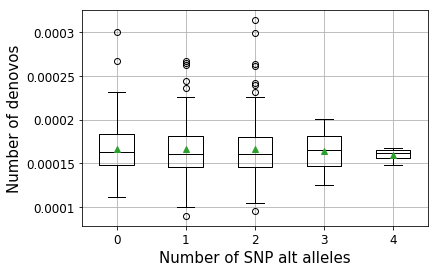

In [138]:
# Plot by HTT SNP status
pthresh = 0.99

htt = pd.read_csv("../other_data/ssc_htt_snp_status.tab", sep="\t", names=["sample","gt"])
ped = pd.read_csv("../../metadata/ssc_family_ids.txt", sep="\t", names=["id","sample"])
sscpop = pd.read_csv("../../metadata/ssc_family_populations.tab", sep="\t")
sscpop = pd.merge(sscpop, bychild_rates[(bychild_rates["status"]==1) & (bychild_rates["pthresh"]==pthresh)],
                  on=["family"])

ped["family"] = ped["id"].apply(lambda x: int(x.split(".")[0]))
ped["rel"] = ped["id"].apply(lambda x: x.split(".")[1])
htt = pd.merge(htt, ped, on=["sample"])
htt = htt[(htt["rel"]=="mo") | (htt["rel"]=="fa")]
htt = pd.merge(htt, sscpop, on=["family"])
htt = htt[htt["Superpop"]=="EUR"]

def AggGT(x):
    total = 0
    for item in x:
        alleles = sum([int(a) for a in item.split("|")])
        total += alleles
    return total
httfam = htt.groupby("family", as_index=False).agg({"gt":AggGT,"rate": np.mean})

fig = plt.figure()
ax = fig.add_subplot(111)
boxprops = dict(linestyle='-', linewidth=1)
medianprops = dict(linestyle='-', linewidth=1)

bp = httfam.boxplot(by="gt", column="rate", ax=ax, boxprops=boxprops,
                medianprops=medianprops, return_type='dict', showmeans=True);
[[item.set_color("black") for item in bp[key]['boxes']] for key in bp.keys()]
[[item.set_color("black") for item in bp[key]['medians']] for key in bp.keys()]
[[item.set_color("black") for item in bp[key]['whiskers']] for key in bp.keys()]

ax.set_title("");
fig.suptitle("")
ax.set_xlabel("");
ax.set_ylabel("Number of denovos", size=15)
ax.set_xlabel("Number of SNP alt alleles", size=15)
ax.set_xticklabels(ax.get_xticklabels(), size=12);
ax.set_yticklabels([(x) for x in ax.get_yticks()], size=12);

scipy.stats.ks_2samp(httfam[httfam["gt"]==0]["rate"],
                     httfam[httfam["gt"]>0]["rate"])

# Scratch

/usr/lib/python3.4/site-packages/ipykernel/__main__.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/lib/python3.4/site-packages/ipykernel/__main__.py:15: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


(0, 460)

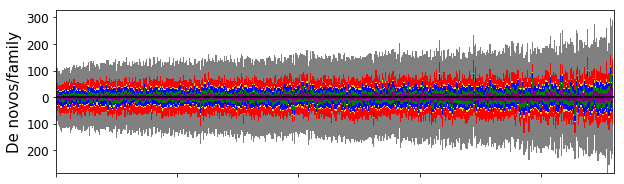

In [132]:
# Plot by period for each family
byfamily = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_byfamily.tab"), sep="\t", names=["family","denovos"])

res_a = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_byfamily_byperiod_affected.tab"), sep="\t",
                 names=["family","period","denovo"])
res_ua = pd.read_csv(os.path.join(RESDIR, "denovos_bylength_byfamily_byperiod_unaffected.tab"), sep="\t",
                 names=["family","period","denovo"])
for period in range(1, 7):
    tmp = res_a[res_a["period"]==period]
    tmp["period%s-a"%period] = tmp["denovo"]
    byfamily = pd.merge(byfamily, tmp[["family","period%s-a"%period]], on="family")
    tmp = res_ua[res_ua["period"]==period]
    tmp["period%s-ua"%period] = tmp["denovo"]
    byfamily = pd.merge(byfamily, tmp[["family","period%s-ua"%period]], on="family")
byfamily = byfamily.sort("denovos")
byfamily = byfamily[byfamily["family"]!=11299]
xvals = range(byfamily.shape[0])
byfamily["yval-ua"] = 0
byfamily["yval-a"] = 0
fig = plt.figure()
fig.set_size_inches((10, 3))
ax = fig.add_subplot(111)
colors = ["gray","red","gold","blue","green","purple"]
for period in [6,5,4,3,2,1]:
    percolor = colors[period-1]
    ax.bar(xvals, byfamily["period%s-ua"%period], bottom=byfamily["yval-ua"], color=percolor, width=1)
    byfamily["yval-ua"] = byfamily["yval-ua"] + byfamily["period%s-ua"%period]
    ax.bar(xvals, -1*(byfamily["period%s-a"%period]), bottom=(-1*byfamily["yval-a"]), color=percolor, width=1)
    byfamily["yval-a"] = byfamily["yval-a"] + byfamily["period%s-a"%period]
ax.axhline(y=0, color="black")
ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("De novos/family", size=15)
ax.set_yticklabels([int(abs(item)) for item in ax.get_yticks()], size=12);
ax.set_xlim(left=0, right=byfamily.shape[0])